In [1]:
import cv2
import numpy as np
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
from skimage.exposure import rescale_intensity
from matplotlib import pyplot as plt
%matplotlib inline

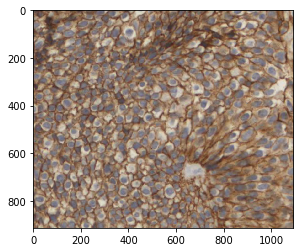

In [11]:
img = cv2.imread("img/cells2.png")
#img = cv2.imread("img/xxx.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

## Option 1: RGB separation

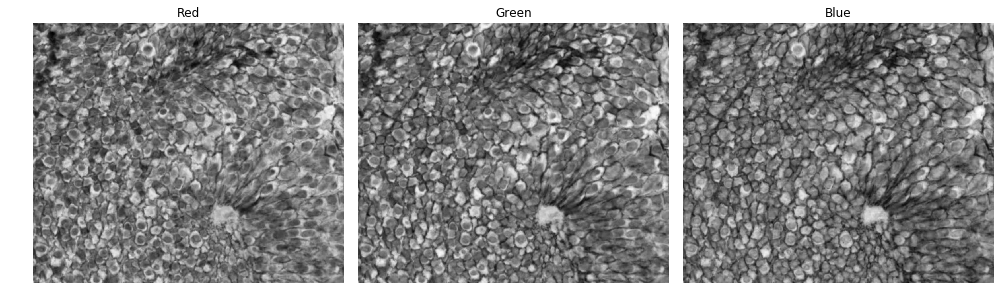

In [12]:
ch = cv2.split(img)
red = ch[0]; green = ch[1]; blue = ch[2]

fig, axes = plt.subplots(1, 3, figsize=(14, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(red, cmap="gray")
ax[0].set_title("Red")

ax[1].imshow(green, cmap="gray")
ax[1].set_title("Green")

ax[2].imshow(blue, cmap="gray")
ax[2].set_title("Blue")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

## Option 2: Staining colors separation

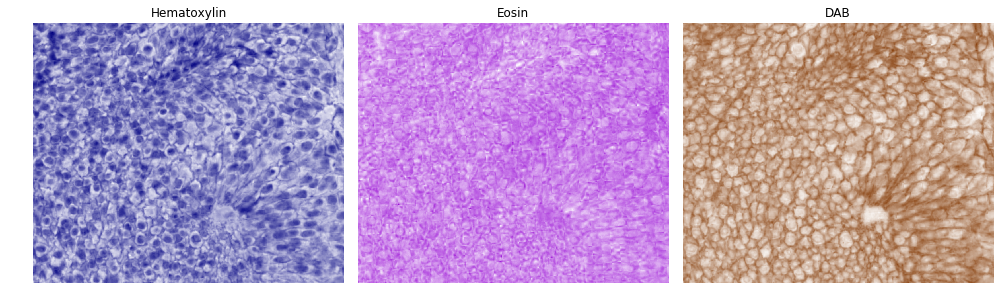

In [13]:
hed   = rgb2hed(img)
blue2 = hed[:, :, 0] # Hematoxylin
pink  = hed[:, :, 1] # Eosin
brown = hed[:, :, 2] # DAB

cmap_hema  = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab   = LinearSegmentedColormap.from_list('mycmap', ['white', 'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['white', 'darkviolet'])

fig, axes = plt.subplots(1, 3, figsize=(14, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(hed[:, :, 0], cmap=cmap_hema)
ax[0].set_title("Hematoxylin")

ax[1].imshow(hed[:, :, 1], cmap=cmap_eosin)
ax[1].set_title("Eosin")

ax[2].imshow(hed[:, :, 2], cmap=cmap_dab)
ax[2].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

## Channel substracction

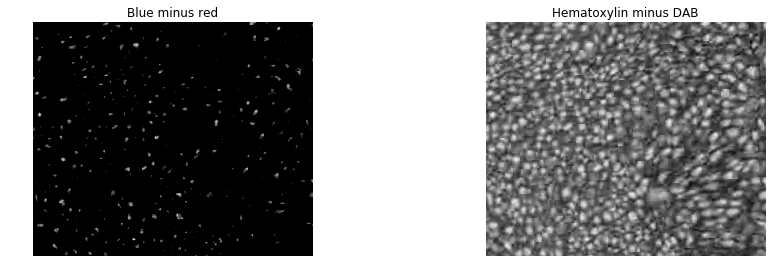

In [14]:
diff_bluered = cv2.subtract(blue, red)

diff = cv2.subtract(blue2, brown)
diff = rescale_intensity(diff, out_range=(0, 255))
diff = np.uint8(diff)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(diff_bluered, cmap="gray")
ax[0].set_title("Blue minus red")

ax[1].imshow(diff, cmap="gray")
ax[1].set_title("Hematoxylin minus DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

## Apply gauss to the substracction

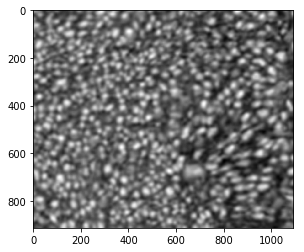

In [15]:
#gauss = cv2.GaussianBlur(r, (11,11), 8)
gauss = cv2.GaussianBlur(diff, (15,15), 15)
plt.imshow(gauss, cmap="gray");

## Thresholding

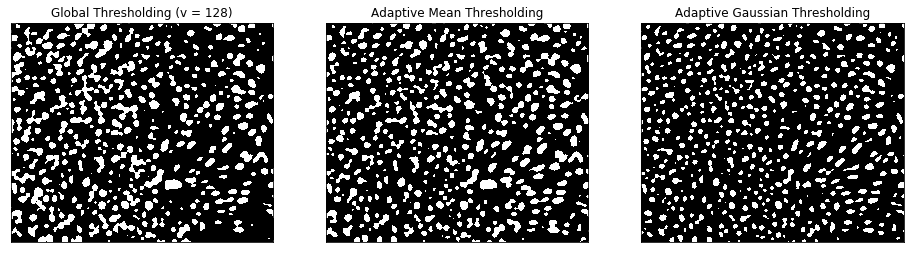

In [40]:
ret,binary1 = cv2.threshold(src=gauss, thresh=128, maxval=255, type=cv2.THRESH_BINARY)
binary2     = cv2.adaptiveThreshold(gauss, 255, cv2.ADAPTIVE_THRESH_MEAN_C,     cv2.THRESH_BINARY, 101, -20)
binary3     = cv2.adaptiveThreshold(gauss, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, -20)


titles = ["Global Thresholding (v = 128)", 'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [binary1, binary2, binary3]


plt.figure(figsize=(16, 16))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

## Connected components (count independent cells)

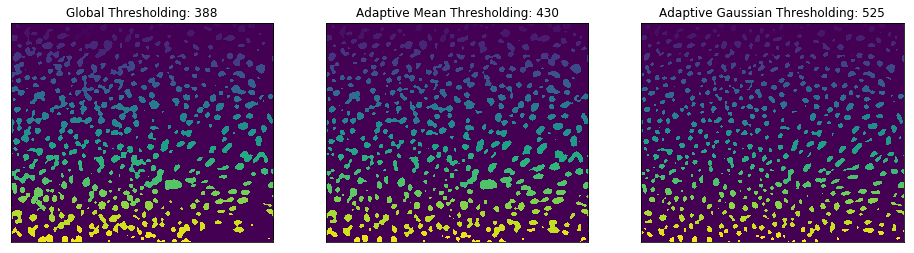

In [46]:
count1, color_bin1 = cv2.connectedComponents(binary1)
count2, color_bin2 = cv2.connectedComponents(binary2)
count3, color_bin3 = cv2.connectedComponents(binary3)

titles = ["Global Thresholding: "           +str(count1-1),
          "Adaptive Mean Thresholding: "    +str(count2-1),
          "Adaptive Gaussian Thresholding: "+str(count3-1)]
images = [color_bin1, color_bin2, color_bin3]


plt.figure(figsize=(16, 16))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

## Draw contours

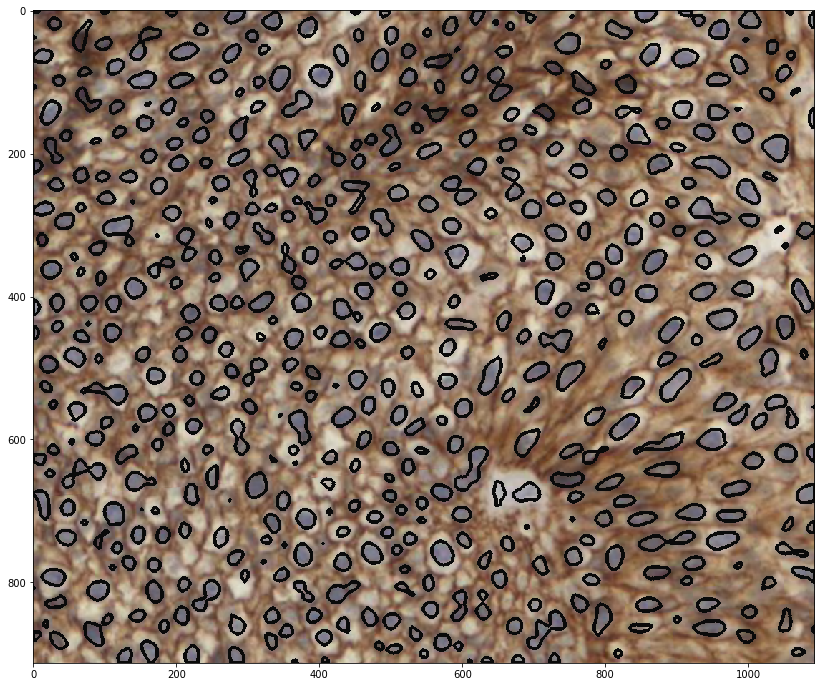

In [47]:
plt.figure(figsize=(14, 14))
_, cont, _ = cv2.findContours(binary3, 1, 2)
img_with_cont = img.copy()
cv2.drawContours(img_with_cont, cont, -1, (10,10,10), 3)
plt.imshow(img_with_cont);

# Segmentation with minmaxloc (Not done)

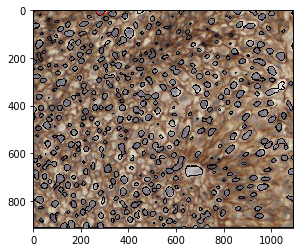

In [8]:
whileminv, maxv, minl, maxl = cv2.minMaxLoc(gauss)
cv2.circle(img, minl, 20, (255,0,0), 2)
plt.imshow(img);

In [9]:
minl

(283, 0)

# Segmentation with Kmeans (Not done)

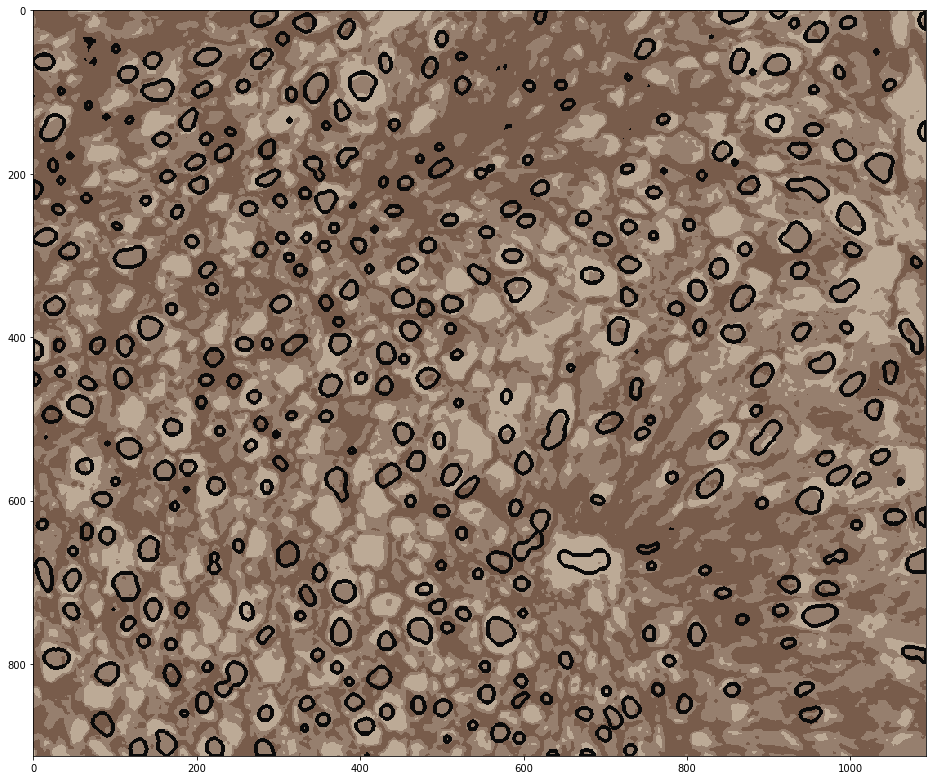

In [34]:
#from sklearn.cluster import KMeans
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center = cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

fig=plt.figure(figsize=(16, 16))
plt.imshow(res2);